## SRPT vs. BASRPT

In [12]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import pickle

path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/testbed_data/ndf50_1s_university_testbed_data.obj'
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['benchmark_data', 'benchmarks', 'envs', 'config'])


In [13]:
%autoreload
# unpack env dicts into list of env objects
envs = tb_dict['envs']



-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_university_load_0.8_repeat_0_scheduler_basrpt'
Measurement duration: 4754065.175768543 (Start time : 594258.1469710679 | End time: 5348323.322739611)
Total number of generated demands (jobs or flows) passed to env: 3000
Total number of these demands which arrived during measurement period: 2381
Total info arrived: 37315474.0 info unit demands arrived
Total info transported: 16144580.0 info unit demands transported
Load (abs): 7.849171734160665 info unit demands arrived per unit time (from first to last flow arriving)
Load (frac): 0.6540976445133887 fraction of network capacity requested (from first to last flow arriving)
Throughput (abs): 3.395952601215667 info units transported per unit time
Throughput (frac): 0.43265107660162644 fraction of arrived info successfully transported

 ~* Flow Information *~
Total number of generated flows passed to env (src != dst, dependency_type == 'data_de

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o



 ~* General Information *~
Simulation name: 'benchmark_university_load_0.6_repeat_0_scheduler_random'
Measurement duration: 7634315.27999998 (Start time : 954289.4099999974 | End time: 8588604.689999977)
Total number of generated demands (jobs or flows) passed to env: 3000
Total number of these demands which arrived during measurement period: 2418
Total info arrived: 48674644.0 info unit demands arrived
Total info transported: 38576373.0 info unit demands transported
Load (abs): 6.375770742336977 info unit demands arrived per unit time (from first to last flow arriving)
Load (frac): 0.5313142285280814 fraction of network capacity requested (from first to last flow arriving)
Throughput (abs): 5.053023301390311 info units transported per unit time
Throughput (frac): 0.7925352879827945 fraction of arrived info successfully transported

 ~* Flow Information *~
Total number of generated flows passed to env (src != dst, dependency_type == 'data_dep'): 3000
Total number of these flows which

/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.style.use('ggplot')
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.style.use('ggplot')
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained unti

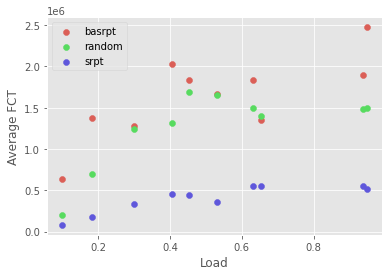

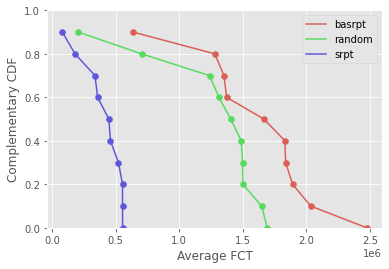

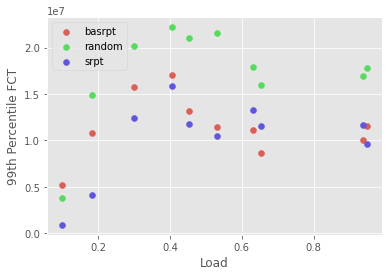

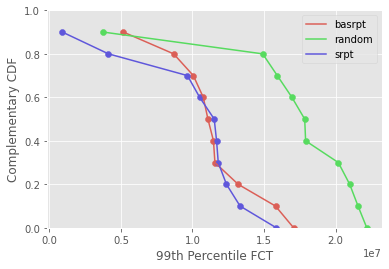

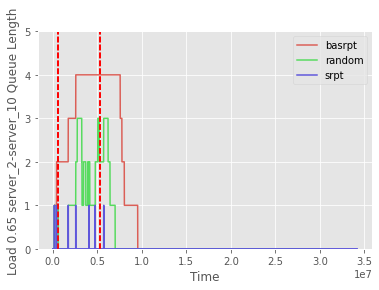

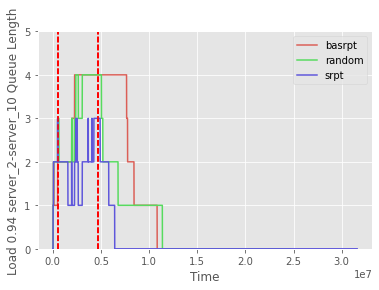

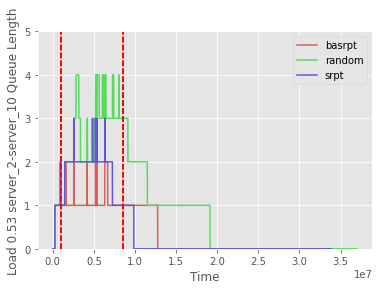

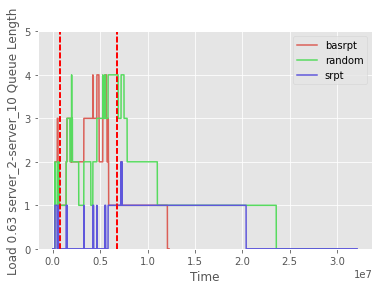

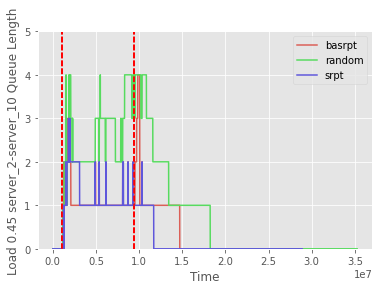

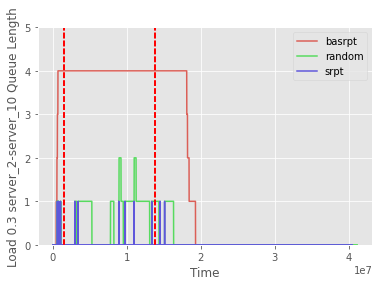

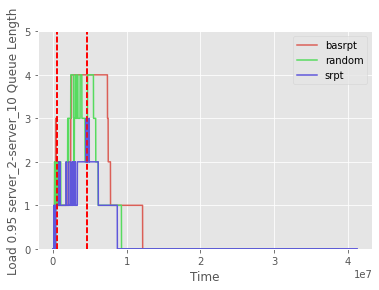

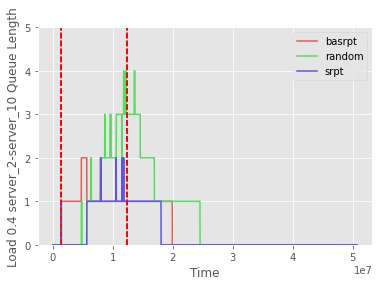

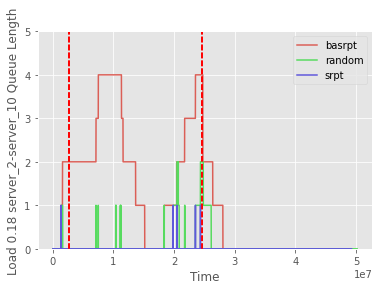

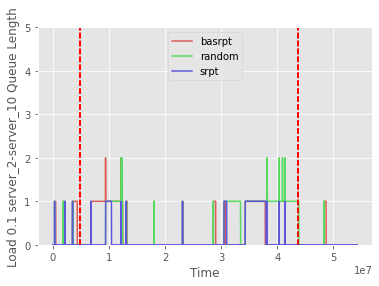

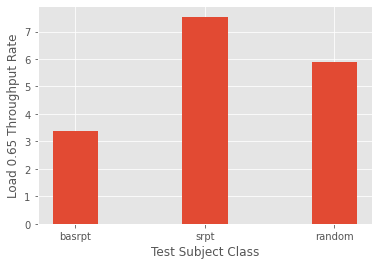

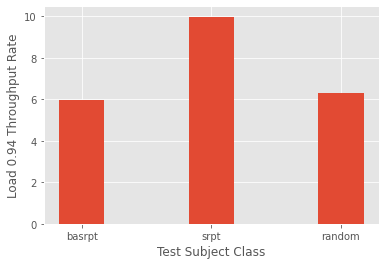

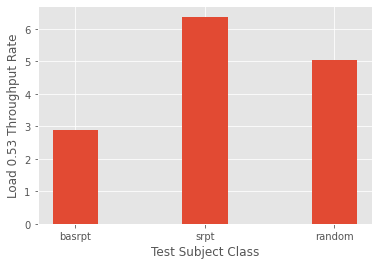

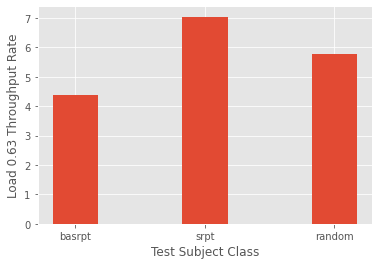

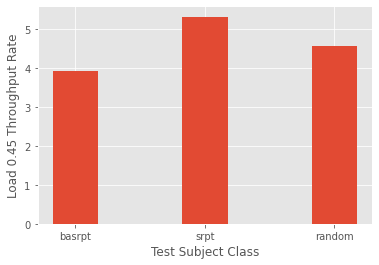

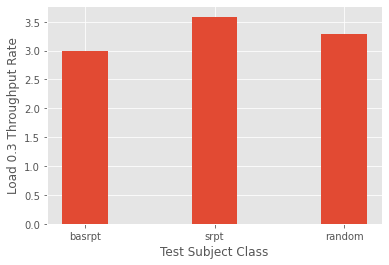

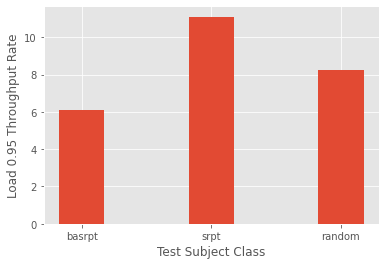

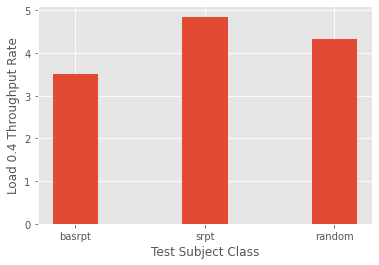

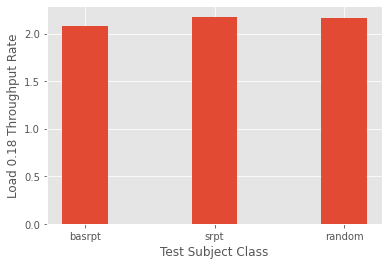

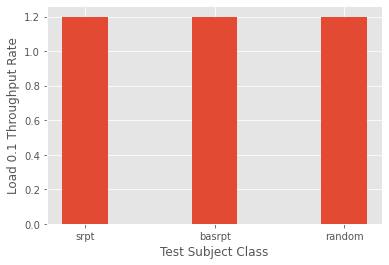

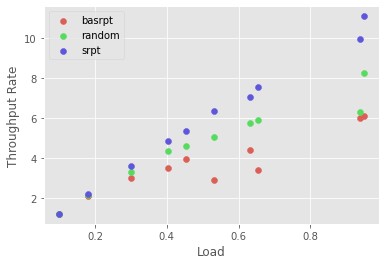

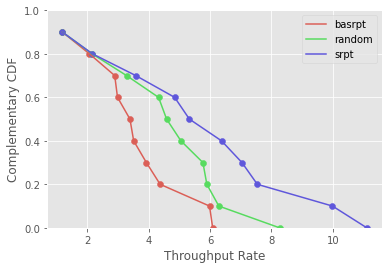

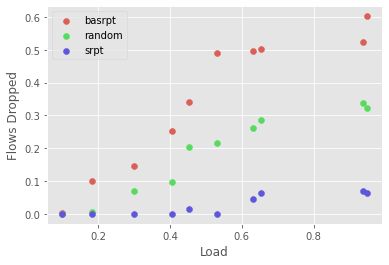

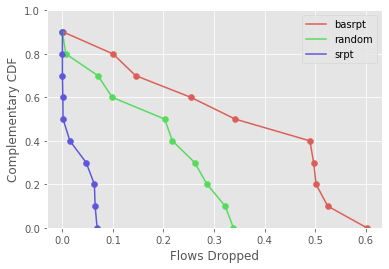

In [14]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

# analyse
analysers = [EnvAnalyser(env, env.scheduler.scheduler_name) for env in envs]
for analyser in analysers:
    analyser.compute_metrics(measurement_start_time='auto',
                             measurement_end_time='auto',
                             print_summary=True)
# plot
plotter = EnvsPlotter()
_ = plotter.plot_average_fct_vs_load(*analysers)
_ = plotter.plot_99th_percentile_fct_vs_load(*analysers)
_ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_num_flows', *analysers)
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_info_units', *analysers)
_ = plotter.plot_throughput_vs_load(*analysers)
_ = plotter.plot_fraction_of_arrived_flows_dropped_vs_load(*analysers)